# import the data

In [1]:
# Importing all the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Import the merged_df
merged_df = pd.read_csv("merged_df.csv")
merged_df.set_index('Datetime', inplace=True)

# Seasonality Predictions

In [3]:
merged_df_2024 = merged_df[(merged_df.index >= '2023-10-01') & (merged_df.index < '9999-01-01')]  # we only look at 2024
merged_df_filtered = merged_df[(merged_df.index >= '2018-01-01') & (merged_df.index < '9999-01-01')]  # we look at everything at first

In [4]:
def calculate_fft(df, variable, threshold_pc):
    # Compute fast Fourier transform
    price_fft = np.fft.fft(df[variable].dropna())

    # Get frequencies corresponding to FFT coefficients
    # d is the interval in terms of days if data is half-hourly, thus frequencies are in cycles per day
    freqs = np.fft.fftfreq(len(price_fft), d=1/48)

    # Calculate amplitudes
    # We need to play with this more I think
    amplitudes = np.abs(price_fft)
    threshold = threshold_pc * np.max(amplitudes)  # Setting a 4% threshold of the maximum amplitude for significance

    # Find frequencies with significant amplitudes
    significant_freqs = freqs[np.where(amplitudes > threshold)]
    significant_amplitudes = amplitudes[np.where(amplitudes > threshold)]
    return zip(significant_freqs, significant_amplitudes)

In [5]:
def prophet_predictions(df, variable, freq_amp):
    # Use Prophet to model_F multiple seasonalities
    prophet_balancing_df = df.reset_index().rename(columns={'Datetime': 'ds', variable: 'y'})
    model_F = Prophet()

    # Adding seasonalities based on significant frequencies
    for freq, amp in freq_amp:
        if freq != 0:  # Ignore the DC component
            period_in_days = 1 / freq
            # Add seasonality to Prophet
            seasonality_name = f"seasonal_freq_{freq:.4f}"
            if period_in_days <= 1:
                fourier_order = 5
            elif period_in_days > 1 and period_in_days > 7:
                fourier_order = 10
            else:
                fourier_order = 20
            model_F.add_seasonality(name=seasonality_name, period=period_in_days, fourier_order=fourier_order)

    # Fit the model_F
    model_F.fit(prophet_balancing_df)

    # Make future dataframe for predictions, 48 * 30 because we need to predict a month
    future = model_F.make_future_dataframe(periods=48 * 30, freq='30T')

    forecast = model_F.predict(future)

    # Plot the forecast
    model_F.plot(forecast)
    plt.show()
    return forecast

In [6]:
# XGBoost template
def xgboo(df, variable):
    df = df.dropna(subset=[variable])
    X = df.drop(columns=["Datetime", variable], axis=1)
    y = df[variable]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train an XGBoost model
    model = XGBRegressor()
    model.fit(X_train, y_train)

    # Get feature importances
    feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    # Filter important features (above a certain threshold, e.g., 0.01)
    important_features = feature_importances[feature_importances > 0.00]
    print("Important features:")
    print(important_features)
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate error metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Print error metrics
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared (R2):", r2)
    

# Seasonality Predictions for System Price

01:10:22 - cmdstanpy - INFO - Chain [1] start processing
01:10:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\ruben\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(


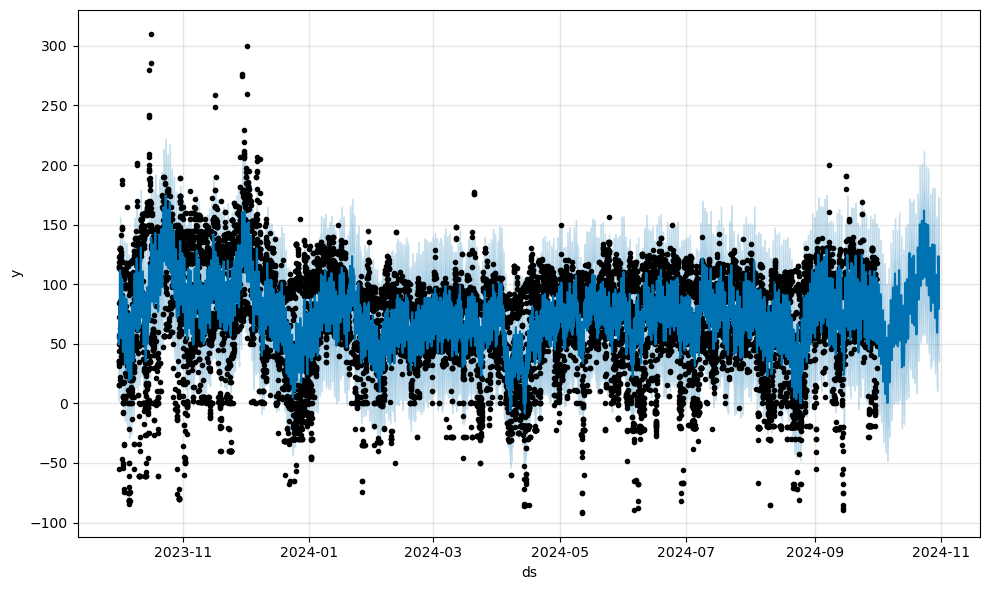

Index(['Datetime', 'System_Price', 'NIV_Outturn', 'BM_Bid_Acceptances',
       'BM_Offer_Acceptances', 'BSAD_Turn_Up', 'BSAD_Turn_Down', 'BSAD_Total',
       'EPEX_Intraday_Volume', 'Loss_of_Load_Prob',
       ...
       'seasonal_freq_2.0000', 'seasonal_freq_2.0000_lower',
       'seasonal_freq_2.0000_upper', 'weekly', 'weekly_lower', 'weekly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object', length=115)

In [6]:
preds_SP = prophet_predictions(merged_df_2024, "System_Price", calculate_fft(merged_df_2024, 'System_Price', 0.03))
# Merging the predictions of prophet to merged df
preds_SP = preds_SP.set_index('ds')
# Convert both indexes to datetime format
preds_SP.index = pd.to_datetime(preds_SP.index)
merged_df_2024.index = pd.to_datetime(merged_df_2024.index)

merged_df_SP = merged_df_2024.join(preds_SP)
merged_df_SP.reset_index(inplace=True)
merged_df_SP.columns

#### Use an ARIMA to predict the trend in residuals that the prophet misses.

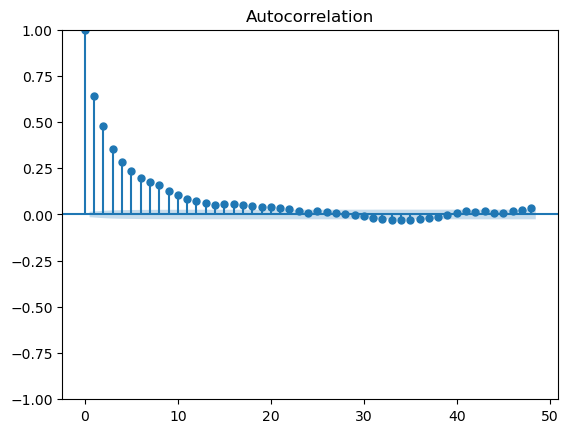

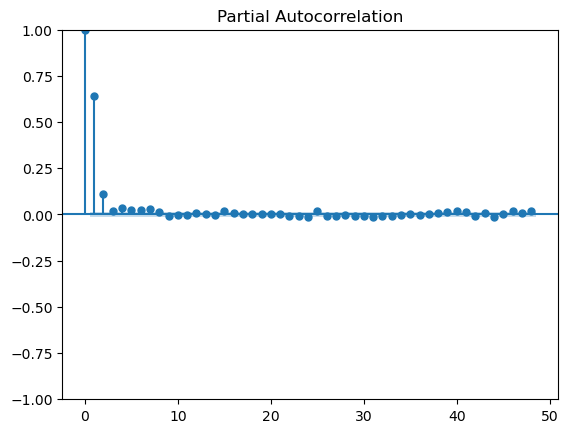

In [7]:
# Step 2: Calculate Residuals
# Calculate residuals as the difference between actual values and Prophet's forecast

merged_df_SP['residuals'] = merged_df_SP["System_Price"] - merged_df_SP['yhat']

# Plot ACF
plot_acf(merged_df_SP['residuals'].dropna(), lags=48)  # 48 lags cover two days if data is half-hourly
plt.show()

# Plot PACF
plot_pacf(merged_df_SP['residuals'].dropna(), lags=48)
plt.show()

d = 0


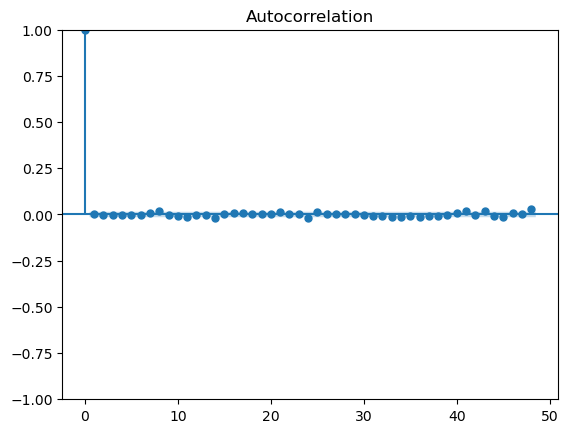

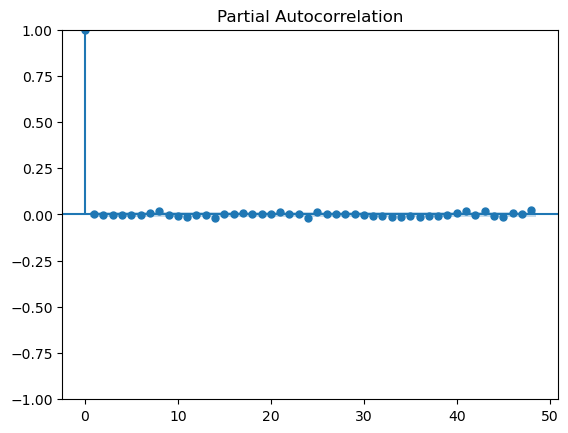

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
# Step 3: Fit ARIMA on the Residuals
# Using the residuals, fit an ARIMA model
if adfuller(merged_df_SP['residuals'])[1] < 0.05:
    d = 0
    print("d = 0")
elif adfuller(merged_df_SP['residuals'].diff().dropna())[1] < 0.05:
    d = 1
    print("d = 1")
else:
    d = 2
    print("d = 2")
p = 2
q = 3
arima_model = ARIMA(merged_df_SP['residuals'].dropna(), order=(p, d, q))
arima_fit = arima_model.fit()
# Forecast residuals using ARIMA
residuals_forecast = arima_fit.predict(start=0, end=len(merged_df_SP) - 1)
residuals_forecast_series = pd.Series(residuals_forecast, index=merged_df_SP.index)
# Step 4: Combine the Predictions
# Add the ARIMA residuals forecast back to the Prophet forecast
merged_df_SP['combined_forecast'] = merged_df_SP['yhat'] + residuals_forecast_series

merged_df_SP['final_residuals'] = merged_df_SP['System_Price'] - merged_df_SP['combined_forecast']
# Plot ACF
plot_acf(merged_df_SP['final_residuals'].dropna(), lags=48)
plt.show()
# Plot PACF
plot_pacf(merged_df_SP['final_residuals'].dropna(), lags=48)
plt.show()

# XGBoost for all vars SP

In [ ]:
merged_df_SP = merged_df_SP.drop(columns=["final_residuals", "residuals", "yhat"], axis=1)
xgboo(merged_df_SP, "System_Price")
print("VS")
merged_df_2024.reset_index(inplace=True)
print(xgboo(merged_df_2024, "System_Price"))

Important features:
NIV_Outturn                        0.259266
trend                              0.201099
combined_forecast                  0.186517
Intraday_Price                     0.119411
seasonal_freq_-0.0027              0.016088
seasonal_freq_0.0027               0.014825
Day_Ahead_Price                    0.014702
Fossil_Gas                         0.012570
seasonal_freq_-0.0082              0.008395
seasonal_freq_-0.0055              0.008081
BSAD_Turn_Down                     0.006861
seasonal_freq_0.0055               0.006242
BSAD_Total                         0.006023
seasonal_freq_-0.0383              0.005372
Nuclear                            0.005131
Biomass                            0.005086
Fossil_Hard_Coal                   0.005069
seasonal_freq_-0.0164              0.005061
BM_Bid_Acceptances                 0.004915
seasonal_freq_0.0082               0.004729
seasonal_freq_-0.0219              0.004616
Hydro_Run-of-River_and_Poundage    0.004424
seasonal_fre

# Seasonality Predictions for NIV

In [8]:
preds_NIV = prophet_predictions(merged_df_filtered, "NIV_Outturn", calculate_fft(merged_df_filtered, 'NIV_Outturn', 0.2))
# Merging the predictions of prophet to merged df
preds_NIV = preds_NIV.set_index('ds')
# Convert both indexes to datetime format
preds_NIV.index = pd.to_datetime(preds_NIV.index)
merged_df_filtered.index = pd.to_datetime(merged_df_filtered.index)

merged_df_NIV = merged_df_filtered.join(preds_NIV)
merged_df_NIV.reset_index(inplace=True)
merged_df_NIV.columns

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ruben\AppData\Roaming\Python\Python312\site-packages\IPython\core\ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ruben\AppData\Roaming\Python\Python312\site-packages\IPython\core\ultratb.py", line 1326, in structured_traceback
    return VerboseTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ruben\AppData\Roaming\Python\Python312\site-packages\IPython\core\ultratb.py", line 1173, in structured_traceback
    formatted_exception = self.format_exception_as_a_whole(etype, evalue, etb, number_of_lines_of_context,
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

#### Use an ARIMA to predict the trend in residuals that the prophet misses.

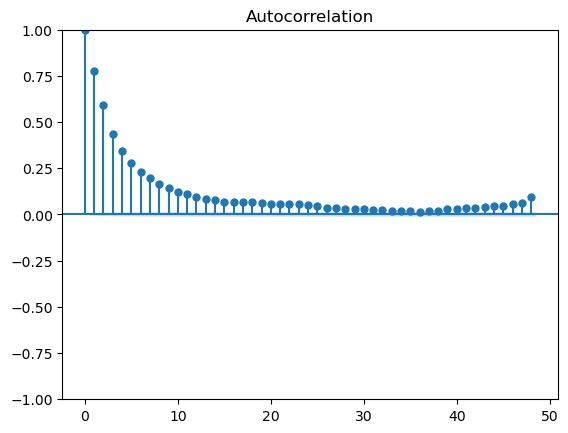

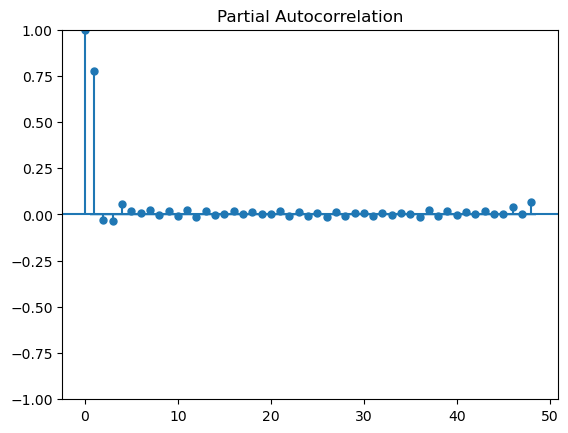

In [ ]:
# Step 2: Calculate Residuals
# Calculate residuals as the difference between actual values and Prophet's forecast

merged_df_NIV['residuals'] = merged_df_NIV["NIV_Outturn"] - merged_df_NIV['yhat']

# Plot ACF
plot_acf(merged_df_NIV['residuals'].dropna(), lags=48)  # 48 lags cover two days if data is half-hourly
plt.show()

# Plot PACF
plot_pacf(merged_df_NIV['residuals'].dropna(), lags=48)
plt.show()

d = 0


c:\Users\ruben\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ruben\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ruben\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ruben\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ruben\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

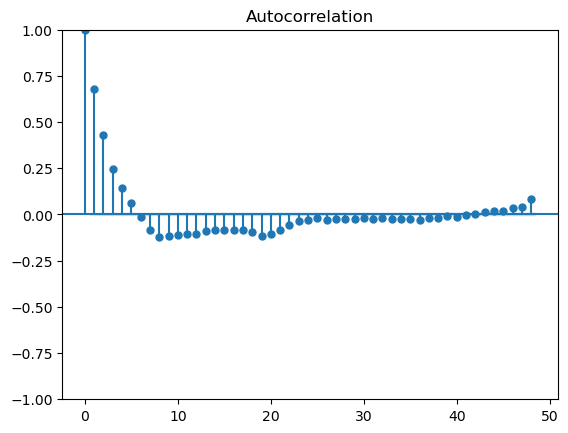

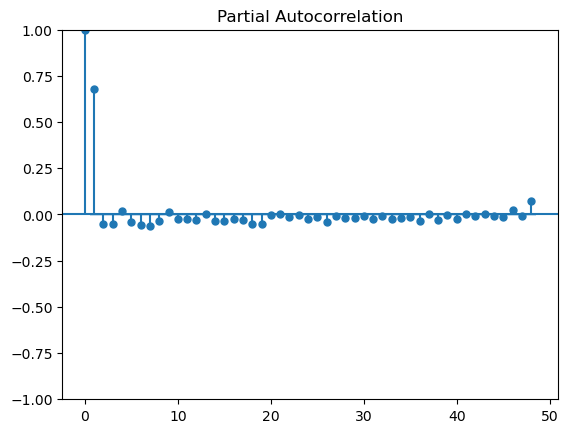

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
# Step 3: Fit ARIMA on the Residuals
# Using the residuals, fit an ARIMA model
if adfuller(merged_df_NIV['residuals'].dropna())[1] < 0.05:
    d = 0
    print("d = 0")
elif adfuller(merged_df_NIV['residuals'].dropna().diff().dropna())[1] < 0.05:
    d = 1
    print("d = 1")
else:
    d = 2
    print("d = 2")
p = 1
q = 3
arima_model = ARIMA(merged_df_NIV['residuals'].dropna(), order=(p, d, q))
arima_fit = arima_model.fit()
# Forecast residuals using ARIMA
residuals_forecast = arima_fit.predict(start=0, end=len(merged_df_NIV) - 1)
residuals_forecast_series = pd.Series(residuals_forecast, index=merged_df_NIV.index)
# Step 4: Combine the Predictions
# Add the ARIMA residuals forecast back to the Prophet forecast
merged_df_NIV['combined_forecast'] = merged_df_NIV['yhat'] + residuals_forecast_series

merged_df_NIV['final_residuals'] = merged_df_NIV["NIV_Outturn"] - merged_df_NIV['combined_forecast']
# Plot ACF
plot_acf(merged_df_NIV['final_residuals'].dropna(), lags=48)
plt.show()
# Plot PACF
plot_pacf(merged_df_NIV['final_residuals'].dropna(), lags=48)
plt.show()

# XGBoost for all vars NIV

In [ ]:
merged_df_NIV = merged_df_NIV.drop(columns=["final_residuals", "residuals", "yhat"], axis=1)
xgboo(merged_df_NIV, "NIV_Outturn")
print("VS")
merged_df_filtered.reset_index(inplace=True)
print(xgboo(merged_df_filtered, "NIV_Outturn"))

Important features:
System_Price                       0.425425
BM_Offer_Acceptances               0.132857
BM_Bid_Acceptances                 0.126632
trend                              0.064427
seasonal_freq_-0.0004              0.031043
yearly                             0.024866
Day_Ahead_Price                    0.023833
BSAD_Turn_Down                     0.021514
seasonal_freq_-0.0089              0.015913
BSAD_Total                         0.008151
BSAD_Turn_Up                       0.007545
Fossil_Gas                         0.006889
Intraday_Price                     0.006598
Demand_Outturn                     0.006520
seasonal_freq_-0.0353              0.005686
Hydro_Run-of-River_and_Poundage    0.005642
seasonal_freq_-1.0002              0.004871
Hydro_Pumped_Storage               0.004351
seasonal_freq_-0.0446              0.004179
Fossil_Hard_Coal                   0.004160
Wind_Onshore                       0.004119
Solar                              0.003889
Total_Genera